<a href="https://colab.research.google.com/github/Nburkhal/DS-Unit-2-Kaggle-Challenge/blob/master/assignment_kaggle_challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 2

## Assignment
- [x] Read [“Adopting a Hypothesis-Driven Workflow”](https://outline.com/5S5tsB), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [x] Continue to participate in our Kaggle challenge.
- [x] Try Ordinal Encoding.
- [x] Try a Random Forest Classifier.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [x] Add your own stretch goal(s) !
- [x] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [ ] Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/).
- [x] Get and plot your feature importances.
- [x] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_






In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module2')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Import necessary modules
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.pipeline import make_pipeline
import category_encoders as ce

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

In [94]:
train.shape, test.shape

((59400, 41), (14358, 40))

In [95]:
# Train/Validate/Test split the data
train, val = train_test_split(
    train, train_size=0.80, test_size=0.20,
    stratify=train['status_group'], random_state=4
)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
        
    # Get more accurate description of lat & lon (3D representation)
    # https://datascience.stackexchange.com/questions/13567/ways-to-deal-with-longitude-latitude-feature
    X['x'] = np.cos(X['latitude']) * np.cos(X['longitude'])
    X['y'] = np.cos(X['latitude']) * np.sin(X['longitude'])
    X['z'] = np.sin(X['latitude'])
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # Engineer Feature: is water quality_group is  good and quantity is enough
    X['good_quality'] = (X['quality_group'] == 'good').astype(int)
    X['enough_quantity'] = (X['quantity'] == 'enough').astype(int)
    X['good_enough'] = ((X['quality_group'] == 'good') & 
                      (X['quantity'] == 'enough')).astype(int)
    
    # Engineer features: is alt greater than 552/ group altitudes into bins
    X['greater_than_552'] = (X['gps_height'] > 552).astype(int)
    X['altitude_group'] = pd.qcut(X['gps_height'], 10, labels=['A', 'B', 'C', 
                                                              'D', 'E', 'F',
                                                              'G', 'H', 'I', 
                                                              'J'])
    
    # return the wrangled dataframe
    return X

In [99]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
train.shape, val.shape, test.shape

((47520, 54), (11880, 54), (14358, 53))

In [100]:
train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,x,y,z,year_recorded,month_recorded,day_recorded,years,years_MISSING,good_quality,enough_quantity,good_enough,greater_than_552,altitude_group
57685,5000.0,Wsdp,112.0,Wachina,38.865788,-6.829784,Mshindo Shabani Bom,102,Wami / Ruvu,Bomu,Pwani,6,2,Kibaha,Soga,20.0,True,Parastatal,upper Ruvu,True,2010.0,mono,mono,motorpump,private operator,commercial,pay monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,functional,False,False,False,False,False,0.335918,0.785483,-0.519785,2011,2,26,1.0,False,1,0,0,0,B
19536,500.0,Unicef,1525.0,DWE,34.664787,-8.984294,Shuleni,0,Rufiji,Mmana,Iringa,11,4,Njombe,Usuka,350.0,True,WUA,wanging'ombe water supply s,True,1984.0,gravity,gravity,gravity,wua,user-group,pay monthly,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,False,False,False,False,False,0.899346,0.096843,-0.426377,2011,10,4,27.0,False,1,1,1,1,H
17706,0.0,Government Of Tanzania,243.0,DWE,38.560631,-9.780829,Barabara Ya Rwangwa,0,Ruvuma / Southern Coast,Luhuma,Lindi,80,43,Liwale,Mirui,250.0,NaN,VWC,NaN,True,2000.0,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,salty,salty,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional,False,False,False,False,False,-0.610437,-0.711239,0.348576,2013,1,18,13.0,False,0,0,0,0,B
38260,0.0,Netherlands,NaN,DWE,34.062483,-3.232824,Upendo,0,Internal,Jilago,Shinyanga,17,2,Maswa,Mpindo,NaN,True,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,other,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional,False,False,True,True,True,0.876292,-0.473088,0.091105,2012,10,5,NaN,True,1,1,1,0,NaN
43503,0.0,Rwssp,NaN,RWSSP,33.204758,-3.866347,Kwa Kangayu,0,Internal,Shabayanda,Shinyanga,17,3,Shinyanga Rural,Tinde,NaN,True,WUG,NaN,True,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,soft,good,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,functional,False,False,True,True,True,0.161945,-0.730937,0.662951,2012,10,17,NaN,True,1,0,0,0,NaN


In [79]:
train['gps_height'].nunique()

2397

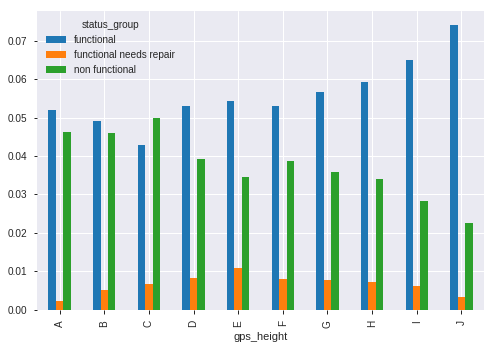

In [101]:
gps_bins = pd.qcut(train['gps_height'], 10, labels=['A', 'B', 'C', 'D', 'E', 
                                                    'F', 'G', 'H', 'I', 'J'])

ct = pd.crosstab(gps_bins, train['status_group'], normalize=True)
ct.plot(kind='bar');

In [103]:
# Select features

# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'x', 'y', 'z', 'year_recorded', 'month_recorded', 'day_recorded', 'years', 'good_quality', 'enough_quantity', 'good_enough', 'greater_than_552', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'longitude_MISSING', 'latitude_MISSING', 'construction_year_MISSING', 'gps_height_MISSING', 'population_MISSING', 'years_MISSING', 'altitude_group']


In [0]:
# Arrange data into X features matrix and y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [112]:
# Random forest model

rf = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'),  
    RandomForestClassifier(n_estimators=300, min_samples_leaf=3, n_jobs=-1, 
                           random_state=42, max_features=.25)
)

# Fit on train
rf.fit(X_train, y_train)

# Score on val
print('Train Accuracy:', rf.score(X_train, y_train))
print('Validation Accuracy:', rf.score(X_val, y_val))

Train Accuracy: 0.9196548821548821
Validation Accuracy: 0.8098484848484848


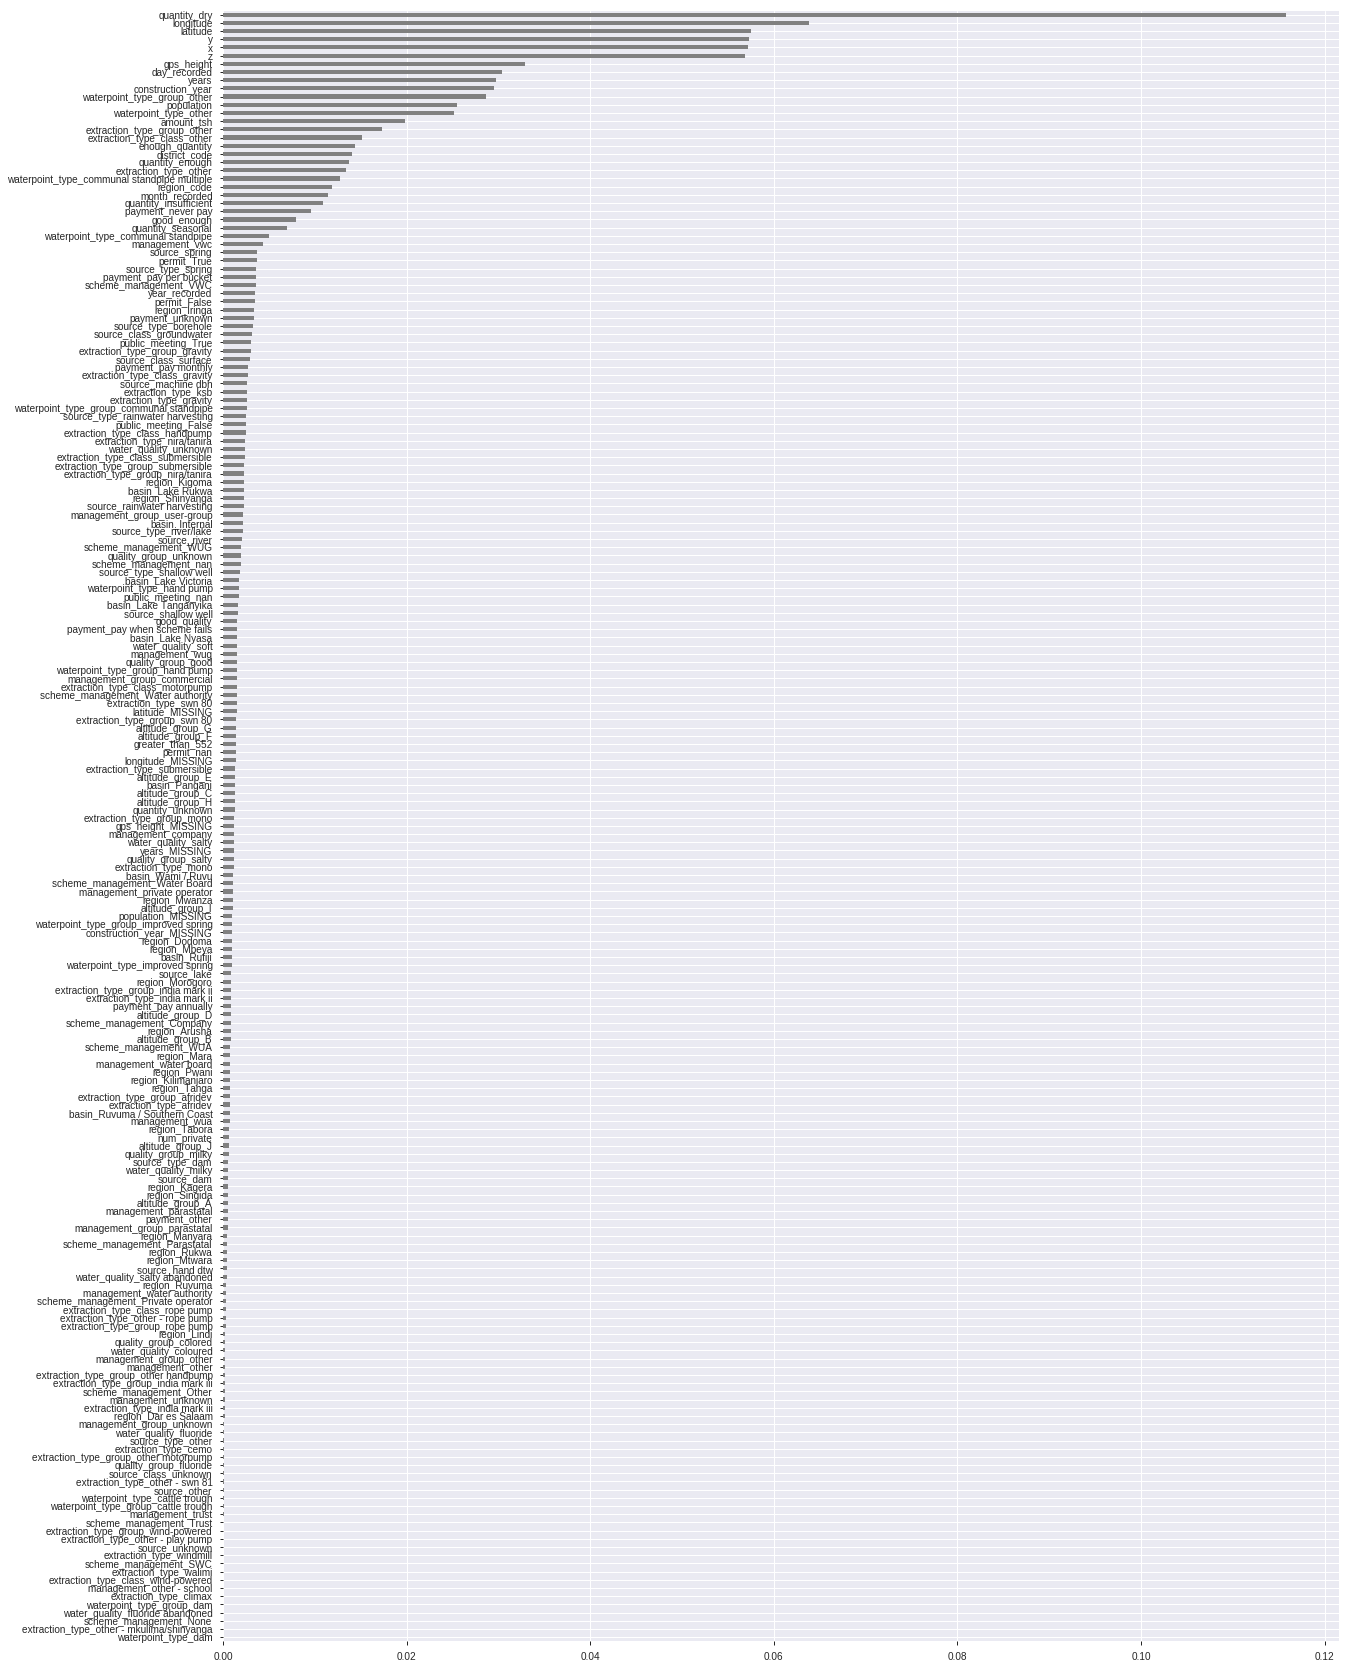

In [119]:
# Plot the feature importances
model = rf.named_steps['randomforestclassifier']
encoder = rf.named_steps['onehotencoder']
encoded_columns = encoder.fit_transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(20,30))
importances.sort_values().plot.barh(color='grey');

In [0]:
assert all(X_train.columns == X_test.columns)

In [0]:
# Predict on test
y_pred = rf.predict(X_test)


# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Burkhalter_DS6_Unit2_submission5.csv', index=False)

In [0]:
from google.colab import files
files.download('Burkhalter_DS6_Unit2_submission5.csv')